In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

Đọc dữ liệu

In [2]:
btc_data = pd.read_csv('DOGE-USD.csv')
exog_data = pd.read_csv('BNB-USD.csv')

Dữ liệu BTC-USD

In [3]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,0.002346,0.002392,0.002322,0.002392,0.002392,17364744
1,1/2/2019,0.002388,0.002458,0.002372,0.002407,0.002407,18015392
2,1/3/2019,0.002404,0.002414,0.002356,0.002360,0.002360,17619234
3,1/4/2019,0.002364,0.002397,0.002274,0.002315,0.002315,19530100
4,1/5/2019,0.002320,0.002350,0.002280,0.002319,0.002319,17148586


Dữ liệu BNB-USD

In [4]:
exog_data.head()

,Date,Close-Exog
0,1/1/2019,6.075273
1,1/2/2019,6.188613
2,1/3/2019,5.903535
3,1/4/2019,6.065138
4,1/5/2019,6.065543


Kết hợp dữ liệu BTC và BNB

In [5]:
data = pd.merge(btc_data, exog_data, on='Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-Exog
0,1/1/2019,0.002346,0.002392,0.002322,0.002392,0.002392,17364744,6.075273
1,1/2/2019,0.002388,0.002458,0.002372,0.002407,0.002407,18015392,6.188613
2,1/3/2019,0.002404,0.002414,0.002356,0.002360,0.002360,17619234,5.903535
3,1/4/2019,0.002364,0.002397,0.002274,0.002315,0.002315,19530100,6.065138
4,1/5/2019,0.002320,0.002350,0.002280,0.002319,0.002319,17148586,6.065543


**Dự đoán 30 ngày cho BNB bằng ARIMA**

In [6]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.8 MB/s eta 0:00:00


In [7]:
eth_data = exog_data[['Date', 'Close-Exog']]
eth_data = exog_data.dropna() # Drop missing values
# eth_data = eth_data.reset_index(drop=True) # Reset the index
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(eth_data))
test_size = int(0.2 * len(eth_data))
val_size = len(eth_data) - train_size - test_size

train_data = eth_data[:train_size]
test_data = eth_data[train_size:train_size+test_size]
val_data = eth_data[train_size+test_size:]
print(eth_data)

            Close-Exog
Date                  
2019-01-01    6.075273
2019-01-02    6.188613
2019-01-03    5.903535
2019-01-04    6.065138
2019-01-05    6.065543
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[1551 rows x 1 columns]


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close-Exog'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8861.886, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8905.891, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8881.960, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8885.892, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8905.033, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8875.774, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8877.807, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8862.449, Time=1.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8876.520, Time=1.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8878.596, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8876.833, Time=2.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8878.858, Time=1.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8851.727, Time=3.92 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=8849.981, Time=4.50 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-Exog'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-Exog'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [10]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  eth_data.index[-1]
print(last_index)
next_30_days_index_eth = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index_eth)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days_eth = np.array(next_30_days_index_eth).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days_eth = model.predict(n_periods=len(x_next_30_days_eth)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_eth)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[532.2459854  532.03753686 525.54816074 527.9659898  532.69919062
 528.10607371 526.75418057 530.78065489 530.28925765 527.04670967
 529.09313125 530.64902998 528.39077659 528.07269931 530.119909
 529.38321132 528.10949918 529.24917293 529.79186114 528.59508095
 528.72314484 529.61707192 529.11871758 528.61112038 529.25578085
 529.36503244 52

Validation RMSE: 236.2426671244934
Testing RMSE: 205.45821136353726
Validation MAPE: 0.8131696460147575
Testing MAPE: 0.6437663918203378


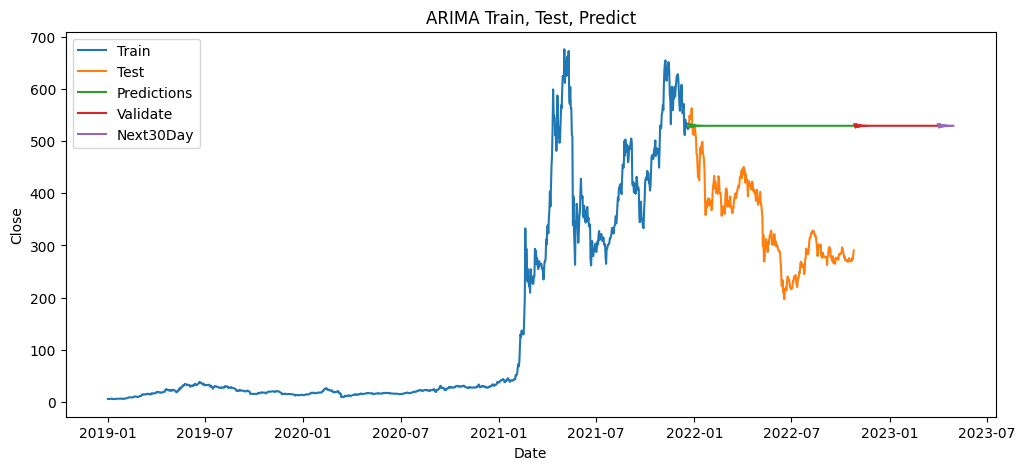

In [11]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-Exog'])
plt.plot(test_data.index, test_data['Close-Exog'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index_eth,y_next_30_days_eth)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [12]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Close-Exog']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

1085
310
156


In [13]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-Exog"]]
model = auto_arima(train_data.Close, 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5978.001, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5946.838, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5963.220, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5960.460, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5948.734, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5971.030, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5965.701, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6000.162, Time=2.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5971.318, Time=0.86 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-5997.722, Time=4.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6020.199, Time=3.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6014.233, Time=3.82 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-6016.709, Time=5.50 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-6020.470, Time=3.74 sec
 ARIMA(2,1,4)(0,0,0

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(1,1,5),
 enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-Exog']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-Exog']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-12-21    0.175076
2021-12-22    0.180025
2021-12-23    0.184306
2021-12-24    0.179398
2021-12-25    0.181380
                ...   
2022-10-22    0.062653
2022-10-23    0.065023
2022-10-24    0.064152
2022-10-25    0.068634
2022-10-26    0.071183
Freq: D, Name: predicted_mean, Length: 310, dtype: float64
            Close-Exog
Date                  
2022-10-27  286.844116
2022-10-28  298.014191
2022-10-29  304.217957
2022-10-30  313.754791
2022-10-31  326.360718
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[156 rows x 1 columns]
2021-12-21    0.071394
2021-12-22    0.079016
2021-12-23    0.079492
2021-12-24    0.081597
2021-12-25    0.086658
                ...   
2022-05-21    0.080001
2022-05-22    0.080992
2022-05-23    0.081241
2022-05-24    0.082410
2022-05-25    0.082612
Freq: D, Name: predicted_mean, Length: 156, dtype: float64


In [16]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)



# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = y_next_30_days_eth) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-12-21    0.176592
2021-12-22    0.179336
2021-12-23    0.174370
2021-12-24    0.173424
2021-12-25    0.175110
2021-12-26    0.173097
2021-12-27    0.172512
2021-12-28    0.174237
2021-12-29    0.174027
2021-12-30    0.172637
2021-12-31    0.173514
2022-01-01    0.174181
2022-01-02    0.173213
2022-01-03    0.173076
2022-01-04    0.173954

In [17]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('Testing MAE: ', mae)
mae = mean_absolute_error(y_val,y_pred_val)
print('Validation MAE: ', mae)


Testing MAE:  0.0126606609706971
Validation MAE:  0.014674932820310734


In [18]:
mse = mean_squared_error(y_test,y_pred)
print('Testing MSE: ', mse)
mse = mean_squared_error(y_val,y_pred_val)
print('Validation MSE: ', mse)

Testing MSE:  0.0002446389636234677
Validation MSE:  0.0003203415104855867


In [19]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('Testing RMSE: ', rmse)
rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print('Validation RMSE: ', rmse)

Testing RMSE:  0.015640938706595192
Validation RMSE:  0.017898086782826447


In [20]:
r2 = r2_score(y_test, y_pred)
print('Testing R-Square:', r2)
r2 = r2_score(y_val, y_pred_val)
print('Validation R-Square: ', r2)

Testing R-Square: 0.8467105364787052
Validation R-Square:  -0.7751094128944889


In [21]:
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('Testing MAPE: ', mape)
mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))
print('Validation MAPE: ', mape)

Testing MAPE:  0.1286739584551562
Validation MAPE:  0.16753440318221893


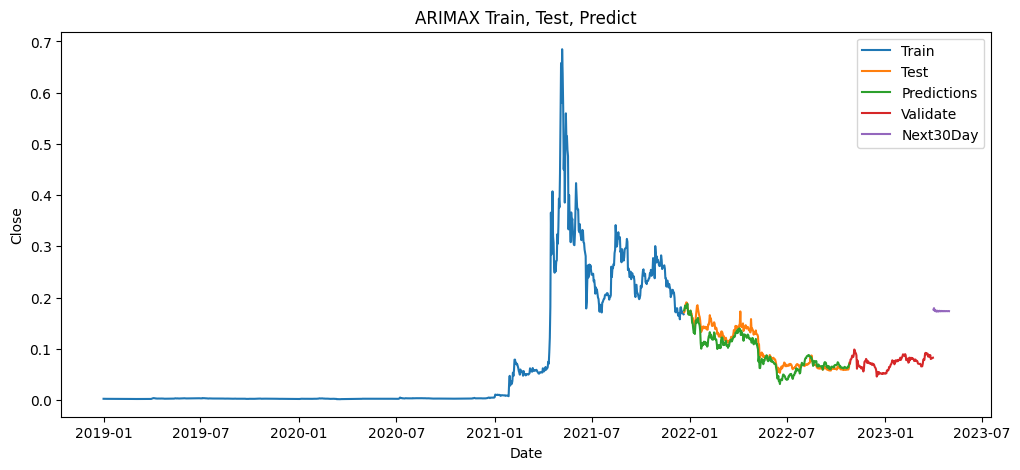

In [22]:
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(next_30_days_index,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()